# Inference from a test VCF file

Try to infer a tstree object like I did with `nf-treeseq` pipeline but using the 
sample VCF provided in [sheepTSexample](https://github.com/HighlanderLab/sheepTSexample)

In [1]:
import cyvcf2
import tsinfer
import tsdate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tskitetude import get_project_dir
from tskitetude.helper import get_chromosome_lengths, add_diploid_sites, create_windows

Configure `tskitetude` module to use `tqdm.notebook`:

In [2]:
from tqdm.notebook import tqdm

import tskitetude.helper

tskitetude.helper.tqdm = tqdm

In [3]:
vcf_file = str(get_project_dir() / "experiments/test1M/test1M.out.inf.vcf.gz")
vcf = cyvcf2.VCF(vcf_file)
chromosome_lengths = get_chromosome_lengths(vcf)

# get first variant like I did in the helper script
variant = next(vcf)
sequence_length = chromosome_lengths[variant.CHROM]

print(f"Getting information for chromosome {variant.CHROM} with length {sequence_length} bp")

Getting information for chromosome 1 with length 1000000 bp


Create `SampleData` object. Add additional information (as we did in [tutorial](https://github.com/HighlanderLab/sheepTSexample/blob/main/Notebooks/10Inference.ipynb)):

In [4]:
# reset the VCF file
vcf = cyvcf2.VCF(vcf_file)

with tsinfer.SampleData(
        path = str(get_project_dir() / "experiments/test1M/test1M.out.inf.samples"),
        sequence_length = sequence_length) as samples:

    # add population information (optional)
    samples.add_population(metadata={"name": "Mouflon"})
    samples.add_population(metadata={"name": "Iranian"})
    samples.add_population(metadata={"name": "Border"})

    # add individuals (optional)

    # create a population lookup list to iterate over
    popID = np.repeat([0,1,2], [5, 50, 50]).tolist()

    # track added individuals
    indv_lookup = {}

    for i in range(105):
        indv_lookup[f"tsk_{i}"] = samples.add_individual(ploidy=2, population=popID[i], metadata={"name": f"tsk_{i}"})

    add_diploid_sites(
        vcf,
        samples,
        ancestors_alleles={},
        indv_lookup=indv_lookup,
        allele_chars=set("01"),
        ancestral_method="reference"
    )

print(
    f"Sample file created for {samples.num_samples} samples "
    f"({samples.num_individuals} individuals) "
    f"with {samples.num_sites} variable sites."
)

/home/cozzip/.cache/pypoetry/virtualenvs/tskitetude-hh-GIRXc-py3.12/lib/python3.12/site-packages/tsinfer/formats.py:530: FutureWarning: The LMDBStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  return zarr.LMDBStore(self.path, subdir=False, map_size=map_size)
/tmp/ipykernel_3037911/3058575067.py:4: DeprecationWarning: SampleData is deprecated
  with tsinfer.SampleData(
2025-12-09 16:33:31,722 - tskitetude.helper - INFO - Using reference allele as ancestral allele


Read VCF:   0%|          | 0/1000000.0 [00:00<?, ?bp/s]

Duplicate entries at position 83850, ignoring all but the first
Duplicate entries at position 119222, ignoring all but the first
Duplicate entries at position 176965, ignoring all but the first
Duplicate entries at position 214451, ignoring all but the first
Duplicate entries at position 231728, ignoring all but the first
Duplicate entries at position 232122, ignoring all but the first
Duplicate entries at position 233613, ignoring all but the first
Duplicate entries at position 250950, ignoring all but the first
Duplicate entries at position 289598, ignoring all but the first
Duplicate entries at position 355578, ignoring all but the first
Duplicate entries at position 368226, ignoring all but the first
Duplicate entries at position 380744, ignoring all but the first
Duplicate entries at position 389742, ignoring all but the first
Duplicate entries at position 401443, ignoring all but the first
Duplicate entries at position 423892, ignoring all but the first
Duplicate entries at posit

/home/cozzip/.cache/pypoetry/virtualenvs/tskitetude-hh-GIRXc-py3.12/lib/python3.12/site-packages/tsinfer/formats.py:104: FutureWarning: The LMDBStore is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  store = zarr.LMDBStore(


In [6]:
# Do the inference
sparrow_ts = tsinfer.infer(
    samples,
    num_threads=4
)

# Simplify the tree sequence
ts = sparrow_ts.simplify()

print(
    f"Inferred tree sequence `ts`: {ts.num_trees} "
    f"trees over {ts.sequence_length / 1e6} Mb"
)

2025-12-09 16:39:04,356 - root - INFO - Max encoded genotype matrix size=2.6 MiB
2025-12-09 16:39:04,360 - tsinfer.inference - INFO - Starting addition of 12844 sites
2025-12-09 16:39:04,764 - tsinfer.inference - INFO - Finished adding sites
2025-12-09 16:39:04,774 - tsinfer.inference - INFO - Ancestor builder peak RAM: 2.0 MiB
2025-12-09 16:39:04,819 - tsinfer.inference - INFO - Starting build for 6469 ancestors
2025-12-09 16:39:07,009 - tsinfer.inference - INFO - Finished building ancestors
2025-12-09 16:39:07,125 - tsinfer.inference - INFO - Mismatch prevented by setting constant high recombination and low mismatch probabilities
2025-12-09 16:39:07,163 - tsinfer.inference - INFO - Summary of recombination probabilities between sites: min=0.01; max=0.01; median=0.01; mean=0.01
2025-12-09 16:39:07,164 - tsinfer.inference - INFO - Summary of mismatch probabilities over sites: min=1e-20; max=1e-20; median=1e-20; mean=1e-20
2025-12-09 16:39:07,165 - tsinfer.inference - INFO - Matching us

Inferred tree sequence `ts`: 5708 trees over 1.0 Mb


In [7]:
ts

In [8]:
# Removes unary nodes (currently required in tsdate), keeps historical-only sites
ts = tsdate.preprocess_ts(ts, filter_sites=False)

ts = tsdate.date(
    ts,
    method="inside_outside",
    mutation_rate=1e-8,
    Ne=1e4
)

ts

2025-12-09 16:39:23,036 - tsdate.util - INFO - Beginning preprocessing
2025-12-09 16:39:23,037 - tsdate.util - INFO - Minimum_gap: None and erase_flanks: None
2025-12-09 16:39:23,039 - tsdate.util - INFO - REMOVING TELOMERE: Snip topology from 0 to first site at 107.0.
2025-12-09 16:39:23,040 - tsdate.util - INFO - REMOVING TELOMERE: Snip topology from 999989.0 to end of sequence at 1000000.0.
2025-12-09 16:39:44,333 - tsdate.core - INFO - Inserted node and mutation metadata in 0.3000633716583252 seconds
2025-12-09 16:39:44,336 - root - INFO - Modified ages of 1860 nodes to satisfy constraints
2025-12-09 16:39:44,337 - tsdate.core - INFO - Constrained node ages in 0.00 seconds
2025-12-09 16:39:44,366 - root - INFO - Set ages of 0 nonsegregating mutations to root times.


dump the *treesequence* file:

In [9]:
# save generated tree
ts.dump(get_project_dir() / "tests/test1M.out.inf.trees")

I want to try to collect the first tree like I did in a previous example:

In [10]:
POS = 108
tree = ts.at(POS)
tree

Now get the intervals of this tree. Then try to filter out edges between those positions:

In [11]:
interval = tree.interval
left_bound = interval.left
right_bound = interval.right

filtered_edges = ts.tables.edges[
    np.logical_and(ts.tables.edges.left >= left_bound, ts.tables.edges.right <= right_bound)]
filtered_edges[:10]

id,left,right,parent,child,metadata
0,108,372,"4,415","2,559",


In [12]:
len(filtered_edges)

1

why so few edges in this cases? How I can draw a tree with so few edges? Maybe the table
itself doesn't model every connection between nodes. Or the way I collect data on edges
is completely wrong.

Can I filter out the nodes in the same way? In this case I don't have a left and right 
position like in the edge table. However, from the edge table I can derive which nodes are
*child* of *parents*:

In [13]:
parents = set(filtered_edges.parent)
childs = set(filtered_edges.child)

node_ids = parents.union(childs)
print(f"Got {len(node_ids)} distinct nodes")


Got 2 distinct nodes


In [14]:
# heavy intensive operation
# tree.draw_svg(
#     size=(800, 400),
#     time_scale="log_time",
# )

## Exploring nucleotide diversity

Calculate diversity *per SNP positions*: use the `create_windows` function and select all the
odd positions:

In [15]:
# remove the 0 values will be enough!
ts_diversity = ts.diversity(windows=create_windows(ts))
ts_diversity = ts_diversity[ts_diversity > 0]
ts_diversity[:10]

array([0.18086124, 0.01895648, 0.00952381, 0.00952381, 0.04670768,
       0.06475279, 0.06475279, 0.00952381, 0.01895648, 0.04670768])

Now let's compare the nucleotide diversity calculated using vcftools: here's the 
command line to calculate nucleotide diversity *per site*:

```bash
cd test
vcftools --gzvcf test1M.out.inf.vcf.gz --out allsamples_pi --site-pi
```

The `allsamples_pi.sites.pi` is a *TSV* file with the positions and the nucleotide diversity. Read it with pandas:

In [16]:
vcftools_diversity = pd.read_csv(get_project_dir() / "experiments/test1M/allsamples_pi.sites.pi", sep="\t")
vcftools_diversity.head()

,CHROM,POS,PI
0,1,108,0.180861
1,1,120,0.018957
2,1,307,0.009524
3,1,355,0.009524
4,1,372,0.046708


In [17]:

print(f"ts_diversity is {len(ts_diversity)} in size")
print(f"vcftools_diversity is {len(vcftools_diversity)} in size")

ts_diversity is 12844 in size
vcftools_diversity is 12885 in size


this dataframe has more values than ts_diversity, since there are duplicated positions. Since I've
dropped duplicated positions in `create_windows`, I need to drop duplicates in this dataframe. However
the diveristy I can misure in those points will be different: 

In [18]:
vcftools_diversity.drop_duplicates(subset='POS', keep='first', inplace=True)

Are this values similar?

In [19]:
np.isclose(ts_diversity, vcftools_diversity["PI"], atol=1e-6).all()

np.True_

Calculate diversity using *branch*:

In [20]:
# remove the 0 values will be enough!
ts_diversity_branch = ts.diversity(mode='branch', windows=create_windows(ts))
ts_diversity_branch = ts_diversity_branch[ts_diversity_branch > 0]
print(ts_diversity_branch[:10])
print(f"ts_diversity_branch is {len(ts_diversity_branch)} in size")

[46964.58318809 46964.58318809 46964.58318809 46964.58318809
 46964.58318809 46964.58318809 46964.58318809 46964.58318809
 45812.75375712 45812.75375712]
ts_diversity_branch is 25579 in size


In [21]:
print(ts.diversity(mode='branch', windows=create_windows(ts))[:10])
print(create_windows(ts)[:10])

[    0.         46964.58318809 46964.58318809 46964.58318809
 46964.58318809 46964.58318809 46964.58318809 46964.58318809
 46964.58318809 45812.75375712]
[  0. 108. 109. 120. 121. 307. 308. 355. 356. 372.]


Try to plot the tow different diversities with vcftools output:

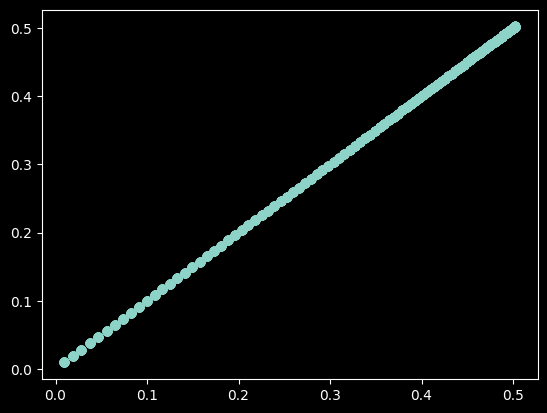

In [22]:
plt.scatter(ts_diversity, vcftools_diversity["PI"])

The *branch* nuclueotide diversity need to be fixed: it doesn't have `0` in positions between windows:

In [23]:
# plt.scatter(ts_diversity_branch, vcftools_diversity["PI"])
# plt.xlim(0, 300)